**Author**: Zidong Chen

**Introduction:** This notebook demonstrates how to implement svgp with mini-batch gradient descent, for detailed mathematical background, please refer to **GPTutorial_svgp**.

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from core.kernel import ARDKernel
import core.GP_CommonCalculation as GP

# Constants
JITTER = 1e-3
PI = 3.1415
torch.manual_seed(4)

# Function to create and initialize model parameters
def create_model(X, Y, num_inducing):
    data = GP.XYdata_normalization(X, Y, 0)
    X_all, Y_all = data.normalize(X, Y)
    kernel = ARDKernel(1)

    xm = nn.Parameter(torch.rand(num_inducing, 1, dtype=torch.float64)) # Inducing points
    qu_mean = nn.Parameter(torch.zeros(num_inducing, 1, dtype=torch.float64))
    chole = nn.Parameter(torch.rand(num_inducing, 1, dtype=torch.float64))
    log_beta = nn.Parameter(torch.ones(1, dtype=torch.float64) * 0)

    return X_all, Y_all, kernel, xm, qu_mean, chole, log_beta

In [9]:
# Function to get a new batch of data
def new_batch(dataloader, iterator):
    try:
        X_batch, Y_batch = next(iterator)
    except StopIteration:
        iterator = iter(dataloader)
        X_batch, Y_batch = next(iterator)
    return X_batch, Y_batch, iterator

In [10]:
# Function to compute variational loss
def variational_loss(X, Y, xm, qu_mean, chole, log_beta, kernel):
    K_mm = kernel(xm, xm) + JITTER * torch.eye(xm.size(0), dtype=torch.float64)
    Lm = torch.linalg.cholesky(K_mm)
    K_mm_inv = torch.cholesky_inverse(Lm)
    K_mn = kernel(xm, X)
    K_nm = K_mn.t()
    qu_S = chole @ chole.t() + JITTER * torch.eye(xm.size(0), dtype=torch.float64)
    Ls = torch.linalg.cholesky(qu_S)
    K_nn = kernel(X, X).diag()
    batch_size = X.size(0)
    mean_vector = K_nm @ K_mm_inv @ qu_mean
    precision = 1 / log_beta.exp()
    K_tilde = precision * (K_nn - (K_nm @ K_mm_inv @ K_mn).diag())
    K_nm_expanded = K_nm.unsqueeze(2)
    K_nm_transposed = K_nm_expanded.transpose(1, 2)
    lambda_mat = torch.matmul(K_nm_expanded, K_nm_transposed)
    lambda_mat = K_mm_inv @ lambda_mat @ K_mm_inv
    batch_matrices = qu_S @ lambda_mat
    traces = precision * torch.einsum('bii->b', batch_matrices)
    
    likelihood_sum = -0.5 * batch_size * torch.log(2 * torch.tensor(PI)) + 0.5 * batch_size * torch.log(log_beta.exp()) - 0.5 * log_beta.exp() * ((Y - K_nm @ K_mm_inv @ qu_mean) ** 2).sum(dim=0).view(-1, 1) - 0.5 * torch.sum(K_tilde) - 0.5 * torch.sum(traces)
    
    logdetS = 2 * Ls.diag().abs().log().sum()
    logdetKmm = 2 * Lm.diag().abs().log().sum()
    KL = 0.5 * (K_mm_inv @ qu_S).diag().sum(dim=0).view(-1, 1) + 0.5 * (qu_mean.t() @ K_mm_inv @ qu_mean) - 0.5 * logdetS + 0.5 * logdetKmm - 0.5 * xm.size(0)
    return likelihood_sum, KL, mean_vector

In [11]:
# Function to evaluate the model
def forward(Xte, xm, qu_mean, chole, kernel):
    K_mm = kernel(xm, xm) + JITTER * torch.eye(xm.size(0), dtype=torch.float64)
    Lm = torch.linalg.cholesky(K_mm)
    K_mm_inv = torch.cholesky_inverse(Lm)
    K_tt = kernel(Xte, Xte)
    K_tm = kernel(Xte, xm)
    K_mt = K_tm.t()
    A = K_tm @ K_mm_inv
    mean = A @ qu_mean
    yvar = K_tt - K_tm @ K_mm_inv @ K_mt + K_tm @ K_mm_inv @ (chole @ chole.t()) @ K_mm_inv @ K_mt
    yvar = yvar.diag().view(-1, 1)
    return mean, yvar

In [12]:
# Initialize training and test data
torch.manual_seed(4)
num_data = 10000
xtr = torch.rand(num_data, 1, dtype=torch.float64)
ytr = ((6 * xtr - 2) ** 2) * torch.sin(12 * xtr - 4) + torch.randn(num_data, 1, dtype=torch.float64) * 0.1
xte = torch.linspace(0, 1, 1000, dtype=torch.float64).view(-1, 1)
yte = ((6 * xte - 2) ** 2) * torch.sin(12 * xte - 4)
normalizer = GP.XYdata_normalization(xtr, ytr, 0)
x_normalized, y_normalized = normalizer.normalize(xtr, ytr)
xte_normalized = normalizer.normalize(xte)

In [26]:
# Model parameters
num_inducing =20
batch_size = 200
learning_rate = 0.1
num_epochs = 500

# Create model
X_all, Y_all, kernel, xm, qu_mean, chole, log_beta = create_model(x_normalized, y_normalized, num_inducing)
dataset = TensorDataset(X_all, Y_all)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
iterator = iter(dataloader)
optimizer = torch.optim.Adam(list(kernel.parameters())+[xm, qu_mean, chole, log_beta], lr=learning_rate)

# Training loop
for i in range(num_epochs):
    optimizer.zero_grad()
    X_batch, Y_batch, iterator = new_batch(dataloader, iterator)
    likelihood, KL, _ = variational_loss(X_batch, Y_batch, xm, qu_mean, chole, log_beta, kernel)
    loss = KL - likelihood * num_data / batch_size  # Negative ELBO
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))

iter 0 nll:18968.40410
iter 10 nll:12144.30587
iter 20 nll:10522.04551
iter 30 nll:7497.41087
iter 40 nll:5148.63316
iter 50 nll:3307.37028
iter 60 nll:1167.68067
iter 70 nll:-263.16727
iter 80 nll:-893.15528
iter 90 nll:-1942.91126
iter 100 nll:-2847.30048
iter 110 nll:-2402.90086
iter 120 nll:-71.97271
iter 130 nll:-5904.18311
iter 140 nll:-8116.02856
iter 150 nll:-9804.77208
iter 160 nll:-12363.50796
iter 170 nll:-8458.98909
iter 180 nll:-11443.98051
iter 190 nll:-12881.73151
iter 200 nll:-14579.39045
iter 210 nll:-16702.91053
iter 220 nll:-14284.09190
iter 230 nll:-14680.90286
iter 240 nll:-8829.35994
iter 250 nll:-13602.86593
iter 260 nll:-14670.06234
iter 270 nll:-16490.33310
iter 280 nll:-18437.47754
iter 290 nll:-18538.48196
iter 300 nll:11088.12079
iter 310 nll:-3774.49851
iter 320 nll:-5421.81398
iter 330 nll:-7459.38590
iter 340 nll:-9806.65487
iter 350 nll:-12182.77857
iter 360 nll:-14335.53344
iter 370 nll:-16110.70003
iter 380 nll:-16952.94536
iter 390 nll:-18211.11905
it

Test MSE: 12.076661065624693


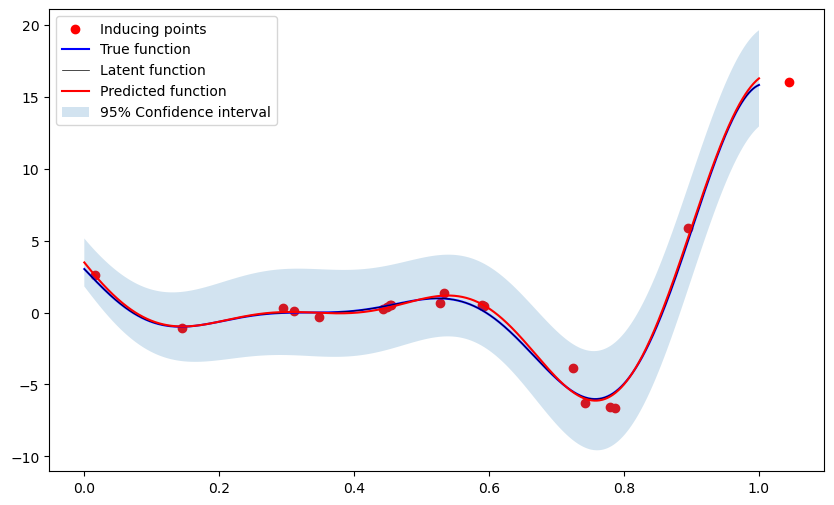

In [29]:
# Evaluate the model
with torch.no_grad():
    predictions, yvar = forward(xte_normalized, xm, qu_mean, chole, kernel)
    xm_denormalized, qu_mean_denormalized = normalizer.denormalize(xm,qu_mean)
    ypred, yvar = normalizer.denormalize_y(predictions, yvar)
    mse = torch.mean((predictions - yte) ** 2)
    print(f'Test MSE: {mse.item()}')

# Plotting results
plt.figure(figsize=(10, 6))
plt.scatter(xm_denormalized, qu_mean_denormalized, color='r', label='Inducing points')
plt.plot(xte.numpy(), yte.numpy(), 'b', label='True function')
#Latent function
plt.plot(xte.numpy(), yte.numpy(), label='Latent function', c='k', lw=0.5)
plt.plot(xte.numpy(), ypred.numpy(), 'r', label='Predicted function')
plt.fill_between(xte.squeeze().numpy(), ypred.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), ypred.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), alpha=0.2, label='95% Confidence interval')
plt.legend()
plt.show()